# imports and helpers

In [2]:
# -*- coding: utf-8 -*-
%reset -f
# Standard library imports
from fractions import Fraction
from itertools import product
from concurrent.futures import ProcessPoolExecutor

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_title(file_name: str) -> str:
    parts = file_name.split('_')
    extracted_info = []
    sensor_range = None
    sensing_range = None

    for part in parts:
        if 'Agents' in part:
            extracted_info.append(part.replace('Agents[', 'Agents: ').replace(']', ''))
        elif 'Preys' in part:
            extracted_info.append(part.replace('Preys[', 'Preys: ').replace(']', ''))
        elif 'steps' in part:
            extracted_info.append(part.replace('steps[', 'Steps: ').replace(']', ''))
        elif 'precentageNoSensor' in part:
            extracted_info.append(part.replace('precentageNoSensor[', 'Percentage No Sensor: ').replace(']', ''))
        elif 'sensingRange' in part:
            sensing_range = int(part.split('[')[1].split(']')[0])
            extracted_info.append(part.replace('sensingRange[', 'Sensing Range: ').replace(']', ''))
        elif 'sensorRange' in part:
            sensor_range = int(part.split('[')[1].split(']')[0])
            extracted_info.append(part.replace('sensorRange[', 'Sensor Range: ').replace(']', ''))

    title = ', '.join(extracted_info)
    return title

columns = ['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
           'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
           'step', 'isPredator']

def compute_order_parameter(angles: np.ndarray) -> float:
    N = len(angles)
    sum_exp = np.sum(np.exp(1j * angles))
    order_parameter = np.abs(sum_exp) / N
    return order_parameter

def plot_data(data: np.ndarray, file_name: str) -> None:
    title = make_title(file_name)
    
    # Convert the NumPy array to a Pandas DataFrame
    df = pd.DataFrame(data, columns=columns)
    
    # Convert columns to appropriate types
    df['step'] = df['step'].astype(int)
    df['isPredator'] = df['isPredator'].astype(int)
    
    # Split into prey and predator DataFrames
    prey_df = df[df['isPredator'] == 0]
    predator_df = df[df['isPredator'] == 1]
    
    # Calculate trajectory means
    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()
    
    # Compute order parameters
    prey_order_parameter = prey_df.groupby('step')['theta'].apply(compute_order_parameter)
    predator_order_parameter = predator_df.groupby('step')['theta'].apply(compute_order_parameter)
    
    # Calculate swarm centers
    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()
    
    # Calculate distance between centers
    distance = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)
    
    last_step = df['step'].max()
    last_steps_positions_predators = predator_df[predator_df['step'] == last_step]
    last_steps_positions_prey = prey_df[prey_df['step'] == last_step]
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    plt.suptitle(title)

    # Plot trajectory
    axs[0].plot(prey_means['x'], prey_means['y'], label='Prey')
    axs[0].plot(predator_means['x'], predator_means['y'], label='Predator')
    axs[0].scatter(last_steps_positions_prey['x'], last_steps_positions_prey['y'], color='blue')
    
    predators_with_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 1]
    predators_without_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 0]
    axs[0].scatter(predators_with_sensor['x'], predators_with_sensor['y'], color='red')
    axs[0].scatter(predators_without_sensor['x'], predators_without_sensor['y'], color='green')
    
    axs[0].quiver(last_steps_positions_prey['x'], last_steps_positions_prey['y'], 
                  np.cos(last_steps_positions_prey['theta']), 
                  np.sin(last_steps_positions_prey['theta']), color='blue')
    axs[0].quiver(predators_with_sensor['x'], predators_with_sensor['y'], 
                  np.cos(predators_with_sensor['theta']), 
                  np.sin(predators_with_sensor['theta']), color='red')
    axs[0].quiver(predators_without_sensor['x'], predators_without_sensor['y'], 
                  np.cos(predators_without_sensor['theta']), 
                  np.sin(predators_without_sensor['theta']), color='green')

    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_title('Trajectory')
    axs[0].legend()

    # Plot order parameter
    axs[1].plot(prey_order_parameter.index, prey_order_parameter, label='Prey')
    axs[1].plot(predator_order_parameter.index, predator_order_parameter, label='Predator')
    axs[1].set_xlabel('step')
    axs[1].set_ylabel('order_parameter')
    axs[1].set_title('Order Parameter')
    axs[1].legend()

    # Plot average distance between the two swarms
    axs[2].plot(prey_means.index, distance)
    axs[2].set_xlabel('step')
    axs[2].set_ylabel('distance')
    axs[2].set_title('Distance between the two swarms')

    # Calculate and smooth velocities
    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2)
    predator_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2)
    
    prey_velocities = prey_velocities.groupby(prey_df['step']).mean()
    predator_velocities = predator_velocities.groupby(predator_df['step']).mean()

    # Apply moving average
    window_size = 1000
    prey_velocities_smoothed = prey_velocities.rolling(window=window_size).mean()
    predator_velocities_smoothed = predator_velocities.rolling(window=window_size).mean()

    axs[3].plot(prey_velocities_smoothed.index, prey_velocities_smoothed, label='Prey')
    axs[3].plot(predator_velocities_smoothed.index, predator_velocities_smoothed, label='Predator')
    axs[3].set_xlabel('step')
    axs[3].set_ylabel('speed')
    axs[3].set_title('Speed')
    axs[3].legend()

    plt.show()

# Example usage:
# data = np.load('data.npy')
# plot_data(data, 'Agents[50]_Preys[100]_steps[200]_precentageNoSensor[20]_sensingRange[10]_sensorRange[15].csv')


# boxplot

In [17]:
file = 'dataPreyPredator/complete_exps50000/Agents[100]_Preys[100]_steps[50000]_precentageNoSensor[0.0]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[12].npy'
data = np.load(file)
print(data.shape)

data = data[data[:, 14] == data[:, 14].max()]
print(data.shape)

(10000000, 16)
(200, 16)


File Agents[100]_Preys[100]_steps[30000]_precentageNoSensor[0.33]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[26].npy not found in folder boxplots


/tmp/ipykernel_509199/1270408603.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{round(1 - float(p), 2)}' for p in percentages])


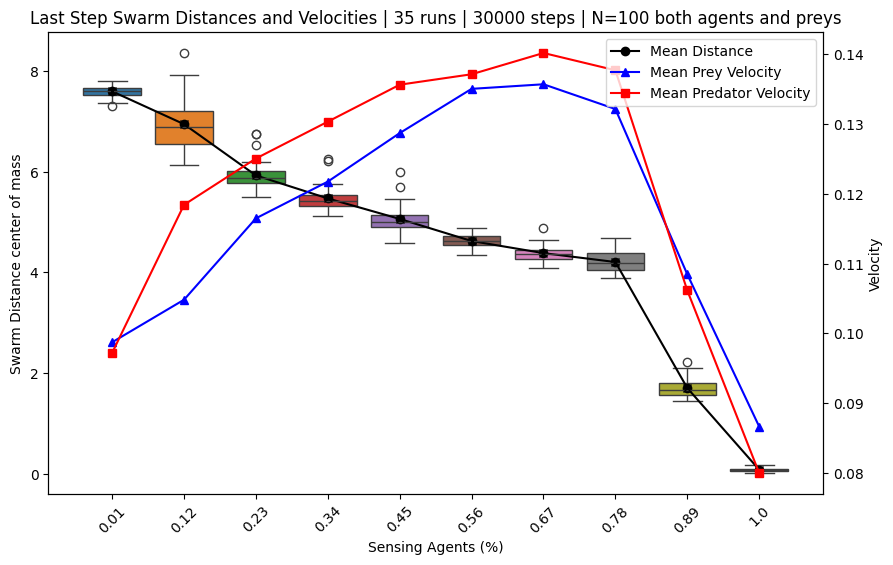

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['boxplots']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100]
N_agent = [100]
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 10)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].npy')

# Initialize variables
experiments = {}


def compute_distances(data: pd.DataFrame) -> tuple:



    prey_df = data[data['isPredator'] == 0]
    predator_df = data[data['isPredator'] == 1]

    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()

    prey_order_parameter = prey_df.groupby('step')['theta'].apply(compute_order_parameter)
    predator_order_parameter = predator_df.groupby('step')['theta'].apply(compute_order_parameter)

    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()

    prey_predator_distances = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)

    # dt = 0.05\

    # For prey
    # prey_df['dt'] = prey_df['step'] * dt  # If 'step' is not a time index but sequential steps, this line might not be necessary

    # prey_grouped = prey_df.groupby('step')
    # prey_x_diffs = prey_grouped['x'].apply(lambda x: np.diff(x) / dt)  # Convert position differences to velocity
    # prey_y_diffs = prey_grouped['y'].apply(lambda y: np.diff(y) / dt)  # Convert position differences to velocity

    # # Calculate the mean velocities at each step
    # prey_velocities = np.sqrt(prey_x_diffs.mean()**2 + prey_y_diffs.mean()**2)

    # # For predators
    # pred_grouped = predator_df.groupby('step')
    # pred_x_diffs = pred_grouped['x'].apply(lambda x: np.diff(x) / dt)  # Convert position differences to velocity
    # pred_y_diffs = pred_grouped['y'].apply(lambda y: np.diff(y) / dt)  # Convert position differences to velocity

    # # Calculate the mean velocities at each step
    # pred_velocities = np.sqrt(pred_x_diffs.mean()**2 + pred_y_diffs.mean()**2)
    # speeds
    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2)
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2)
    # pred_velocities = np.zeros(len(prey_velocities))


    return prey_means, prey_predator_distances, predator_order_parameter, prey_velocities, pred_velocities

# Load and process data
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            # df = df[df['step'] == df['step'].max()]
            # take the last 2 steps
            df = df[df['step'] >= df['step'].max() - 1]
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]

            # _, prey_predator_distances, _ = compute_distances(df)
            prey_means, prey_predator_distances, _, prey_velocities, pred_velocities = compute_distances(df)
            # print(prey_velocities, pred_velocities)
            prey_predator_distances_last_step = prey_predator_distances[-1]
            if (exp_id, percentage_no_sensor) not in experiments:
                experiments[(exp_id, percentage_no_sensor)] = []
            experiments[(exp_id, percentage_no_sensor)].append((prey_predator_distances_last_step, exp_id, prey_velocities, pred_velocities))
            
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]







# Aggregate data across all experiment IDs for each condition
distances_per_percentage = {}
prey_velocities_per_percentage = {}
pred_velocities_per_percentage = {}

for key, distances in experiments.items():
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in distances_per_percentage:
        distances_per_percentage[percentage_no_sensor] = []
    distances_per_percentage[percentage_no_sensor].extend(distances)
    if percentage_no_sensor not in prey_velocities_per_percentage:
        prey_velocities_per_percentage[percentage_no_sensor] = []
    prey_velocities_per_percentage[percentage_no_sensor].extend([x[2] for x in distances])
    if percentage_no_sensor not in pred_velocities_per_percentage:
        pred_velocities_per_percentage[percentage_no_sensor] = []
    pred_velocities_per_percentage[percentage_no_sensor].extend([x[3] for x in distances])


# for percentage in distances_per_percentage:
#     distances_per_percentage[percentage] = remove_outliers(distances_per_percentage[percentage])


# Prepare data for boxplot
percentages = sorted(map(float, distances_per_percentage.keys()), reverse=True)
boxplot_data = [list(map(lambda x: x[0], distances_per_percentage[str(p)])) for p in percentages]
exp_ids = [list(map(lambda x: x[1], distances_per_percentage[str(p)])) for p in percentages]
# Prepare data for velocities - averaging prey and predator velocities for simplicity
prey_velocity_data = [np.mean(prey_velocities_per_percentage[str(p)]) for p in percentages]
pred_velocity_data = [np.mean(pred_velocities_per_percentage[str(p)]) for p in percentages]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot distances
sns.boxplot(data=boxplot_data, ax=ax1, showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, showfliers=True)
mean_distances = [np.mean(distances) for distances in boxplot_data]
ax1.set_xticklabels([f'{round(1 - float(p), 2)}' for p in percentages])
ax1.plot(range(len(mean_distances)), mean_distances, color='black', label='Mean Distance', marker='o')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Sensing Agents (%)')
ax1.set_ylabel('Swarm Distance center of mass')



# for i, (box, exps) in enumerate(zip(boxplot_data, exp_ids)):
#     x = np.random.normal(i + 1, 0.04, size=len(box))  # add some jitter to x-axis
#     ax1.scatter(x, box, alpha=0.6, color='red')
#     for xi, yi, exp_id in zip(x, box, exps):
#         ax1.text(xi, yi, exp_id, fontsize=8, alpha=0.75, ha='right')


# Create a second y-axis for velocities
ax2 = ax1.twinx()
ax2.plot(range(len(prey_velocity_data)), prey_velocity_data, color='blue', label='Mean Prey Velocity', marker='^')
ax2.plot(range(len(pred_velocity_data)), pred_velocity_data, color='red', label='Mean Predator Velocity', marker='s')
ax2.set_ylabel('Velocity')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax1.set_title('Last Step Swarm Distances and Velocities | 35 runs | 30000 steps | N=100 both agents and preys')
plt.show()

# fig, ax = plt.subplots(figsize=(10, 6))

# # Use seaborn boxplot to plot the data
# sns.boxplot(data=boxplot_data, ax=ax, showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, showfliers=True)
# ax.set_xticklabels([f'{round(1 - float(p), 2)}' for p in percentages])

# # Add the mean line using the same mean calculation as the boxplot
# mean_distances = [np.mean(distances) for distances in boxplot_data]
# ax.plot(range(len(mean_distances)), mean_distances, color='black', label='Mean Across All Experiments', marker='o')




# ax.tick_params(axis='x', rotation=45)
# ax.set_xlabel('Sensing Agents (%)')
# ax.set_ylabel('Swarm Distance center of mass')
# ax.set_title('Last Step Swarm Distances | 40 runs | 50000 steps | N=100 both agents and preys')
# plt.legend()
# plt.show()


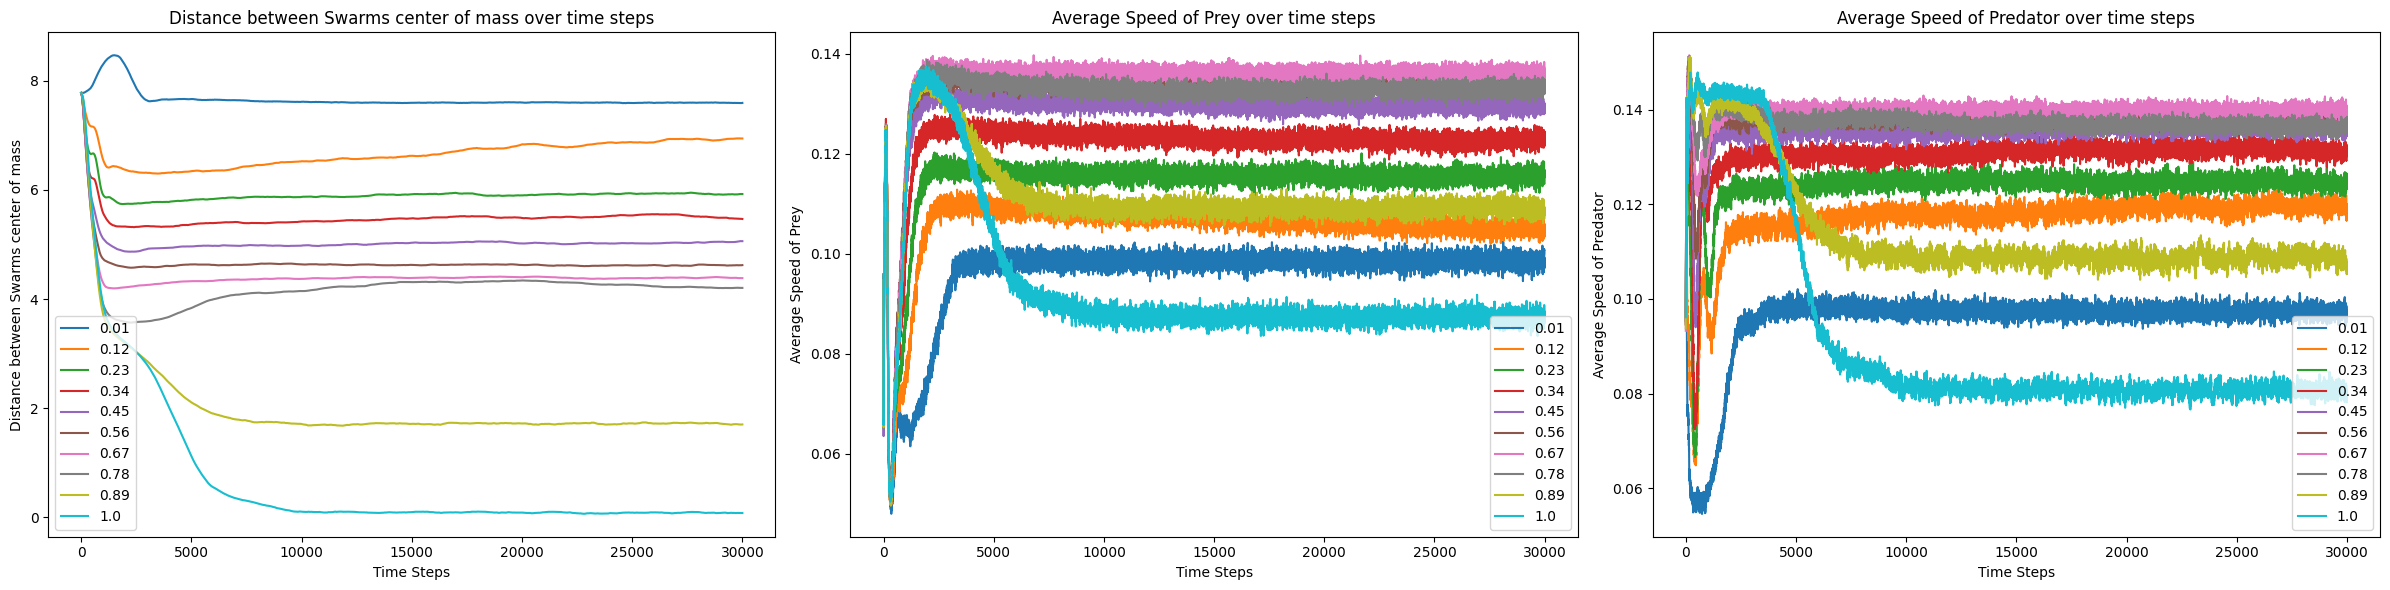

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['boxplots']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100]
N_agent = [100]
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 10)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].npy')

# Initialize variables
experiments = {}

def compute_distances(data: pd.DataFrame) -> tuple:
    prey_df = data[data['isPredator'] == 0]
    predator_df = data[data['isPredator'] == 1]

    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()

    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()

    prey_predator_distances = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)

    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2).groupby(prey_df['step']).mean()
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2).groupby(predator_df['step']).mean()

    return prey_predator_distances, prey_velocities, pred_velocities

# Load and process data
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]

            prey_predator_distances, prey_velocities, pred_velocities = compute_distances(df)
            
            if (exp_id, percentage_no_sensor) not in experiments:
                experiments[(exp_id, percentage_no_sensor)] = []
            experiments[(exp_id, percentage_no_sensor)].append((prey_predator_distances, prey_velocities, pred_velocities))
            
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Aggregate data across all experiment IDs for each condition
distance_data = {}
prey_velocity_data = {}
pred_velocity_data = {}

for key, data in experiments.items():
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in distance_data:
        distance_data[percentage_no_sensor] = []
    if percentage_no_sensor not in prey_velocity_data:
        prey_velocity_data[percentage_no_sensor] = []
    if percentage_no_sensor not in pred_velocity_data:
        pred_velocity_data[percentage_no_sensor] = []

    for distances, prey_velocities, pred_velocities in data:
        distance_data[percentage_no_sensor].append(distances)
        prey_velocity_data[percentage_no_sensor].append(prey_velocities)
        pred_velocity_data[percentage_no_sensor].append(pred_velocities)

# Calculate average distances and velocities over time
avg_distances = {p: np.mean(np.vstack(distance_data[p]), axis=0) for p in distance_data}
avg_prey_velocities = {p: np.mean(np.vstack(prey_velocity_data[p]), axis=0) for p in prey_velocity_data}
avg_pred_velocities = {p: np.mean(np.vstack(pred_velocity_data[p]), axis=0) for p in pred_velocity_data}

fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

# Plot distances
for p in sorted(avg_distances.keys(), reverse=True):
    ax[0].plot(avg_distances[p], label=f'{round(1 - float(p), 2)}')
ax[0].set_xlabel('Time Steps')
ax[0].set_ylabel('Distance between Swarms center of mass')
ax[0].set_title('Distance between Swarms center of mass over time steps')
ax[0].legend()

# Plot average prey velocities over time
for p in sorted(avg_prey_velocities.keys(), reverse=True):
    ax[1].plot(avg_prey_velocities[p], label=f'{round(1 - float(p), 2)}')
ax[1].set_xlabel('Time Steps')
ax[1].set_ylabel('Average Speed of Prey')
ax[1].set_title('Average Speed of Prey over time steps')
ax[1].legend()

# Plot average predator velocities over time
for p in sorted(avg_pred_velocities.keys(), reverse=True):
    ax[2].plot(avg_pred_velocities[p], label=f'{round(1 - float(p), 2)}')
ax[2].set_xlabel('Time Steps')
ax[2].set_ylabel('Average Speed of Predator')
ax[2].set_title('Average Speed of Predator over time steps')
ax[2].legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_646126/2665768577.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{round(1 - float(p), 2)}' for p in percentages])


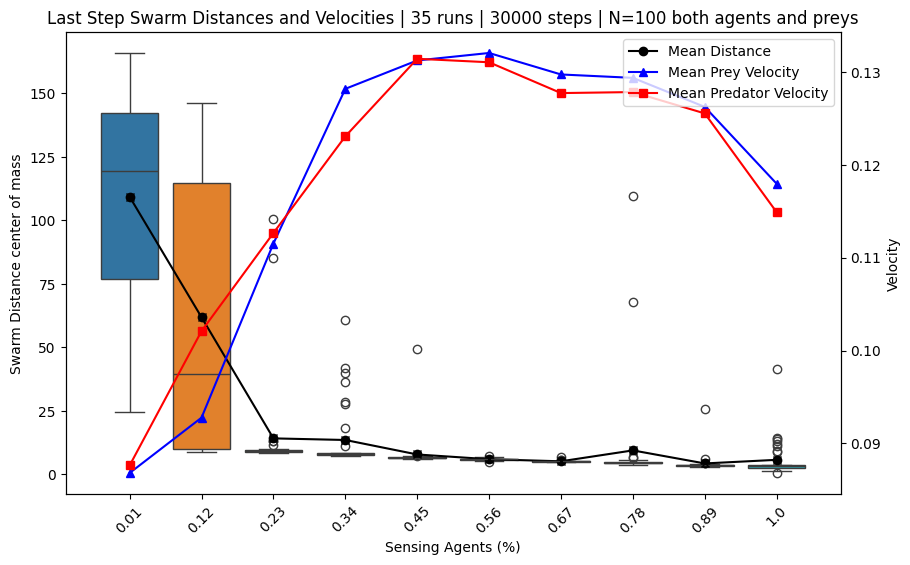

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['boxplots_normalP_vector']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100]
N_agent = [100]
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 10)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[False]_exp[{exp_id}].npy')

# Initialize variables
experiments = {}


def compute_distances(data: pd.DataFrame) -> tuple:



    prey_df = data[data['isPredator'] == 0]
    predator_df = data[data['isPredator'] == 1]

    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()

    prey_order_parameter = prey_df.groupby('step')['theta'].apply(compute_order_parameter)
    predator_order_parameter = predator_df.groupby('step')['theta'].apply(compute_order_parameter)

    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()

    prey_predator_distances = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)

    dt = 0.05

    # For prey
    # prey_df['dt'] = prey_df['step'] * dt  # If 'step' is not a time index but sequential steps, this line might not be necessary

    # prey_grouped = prey_df.groupby('step')
    # prey_x_diffs = prey_grouped['x'].apply(lambda x: np.diff(x) / dt)  # Convert position differences to velocity
    # prey_y_diffs = prey_grouped['y'].apply(lambda y: np.diff(y) / dt)  # Convert position differences to velocity

    # # Calculate the mean velocities at each step
    # prey_velocities = np.sqrt(prey_x_diffs.mean()**2 + prey_y_diffs.mean()**2)

    # # For predators
    # pred_grouped = predator_df.groupby('step')
    # pred_x_diffs = pred_grouped['x'].apply(lambda x: np.diff(x) / dt)  # Convert position differences to velocity
    # pred_y_diffs = pred_grouped['y'].apply(lambda y: np.diff(y) / dt)  # Convert position differences to velocity

    # # Calculate the mean velocities at each step
    # pred_velocities = np.sqrt(pred_x_diffs.mean()**2 + pred_y_diffs.mean()**2)
    # speeds
    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2)
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2)
    # pred_velocities = np.zeros(len(prey_velocities))


    return prey_means, prey_predator_distances, predator_order_parameter, prey_velocities, pred_velocities

# Load and process data
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            # df = df[df['step'] == df['step'].max()]
            # take the last 2 steps
            df = df[df['step'] >= df['step'].max() - 1]
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]

            # _, prey_predator_distances, _ = compute_distances(df)
            prey_means, prey_predator_distances, _, prey_velocities, pred_velocities = compute_distances(df)
            # print(prey_velocities, pred_velocities)
            prey_predator_distances_last_step = prey_predator_distances[-1]
            if (exp_id, percentage_no_sensor) not in experiments:
                experiments[(exp_id, percentage_no_sensor)] = []
            experiments[(exp_id, percentage_no_sensor)].append((prey_predator_distances_last_step, exp_id, prey_velocities, pred_velocities))
            
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]







# Aggregate data across all experiment IDs for each condition
distances_per_percentage = {}
prey_velocities_per_percentage = {}
pred_velocities_per_percentage = {}

for key, distances in experiments.items():
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in distances_per_percentage:
        distances_per_percentage[percentage_no_sensor] = []
    distances_per_percentage[percentage_no_sensor].extend(distances)
    if percentage_no_sensor not in prey_velocities_per_percentage:
        prey_velocities_per_percentage[percentage_no_sensor] = []
    prey_velocities_per_percentage[percentage_no_sensor].extend([x[2] for x in distances])
    if percentage_no_sensor not in pred_velocities_per_percentage:
        pred_velocities_per_percentage[percentage_no_sensor] = []
    pred_velocities_per_percentage[percentage_no_sensor].extend([x[3] for x in distances])


# for percentage in distances_per_percentage:
#     distances_per_percentage[percentage] = remove_outliers(distances_per_percentage[percentage])


# Prepare data for boxplot
percentages = sorted(map(float, distances_per_percentage.keys()), reverse=True)
boxplot_data = [list(map(lambda x: x[0], distances_per_percentage[str(p)])) for p in percentages]
exp_ids = [list(map(lambda x: x[1], distances_per_percentage[str(p)])) for p in percentages]
# Prepare data for velocities - averaging prey and predator velocities for simplicity
prey_velocity_data = [np.mean(prey_velocities_per_percentage[str(p)]) for p in percentages]
pred_velocity_data = [np.mean(pred_velocities_per_percentage[str(p)]) for p in percentages]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot distances
sns.boxplot(data=boxplot_data, ax=ax1, showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, showfliers=True)
mean_distances = [np.mean(distances) for distances in boxplot_data]
ax1.set_xticklabels([f'{round(1 - float(p), 2)}' for p in percentages])
ax1.plot(range(len(mean_distances)), mean_distances, color='black', label='Mean Distance', marker='o')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Sensing Agents (%)')
ax1.set_ylabel('Swarm Distance center of mass')



# for i, (box, exps) in enumerate(zip(boxplot_data, exp_ids)):
#     x = np.random.normal(i + 1, 0.04, size=len(box))  # add some jitter to x-axis
#     ax1.scatter(x, box, alpha=0.6, color='red')
#     for xi, yi, exp_id in zip(x, box, exps):
#         ax1.text(xi, yi, exp_id, fontsize=8, alpha=0.75, ha='right')


# Create a second y-axis for velocities
ax2 = ax1.twinx()
ax2.plot(range(len(prey_velocity_data)), prey_velocity_data, color='blue', label='Mean Prey Velocity', marker='^')
ax2.plot(range(len(pred_velocity_data)), pred_velocity_data, color='red', label='Mean Predator Velocity', marker='s')
ax2.set_ylabel('Velocity')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax1.set_title('Last Step Swarm Distances and Velocities | 35 runs | 30000 steps | N=100 both agents and preys')
plt.show()

# fig, ax = plt.subplots(figsize=(10, 6))

# # Use seaborn boxplot to plot the data
# sns.boxplot(data=boxplot_data, ax=ax, showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, showfliers=True)
# ax.set_xticklabels([f'{round(1 - float(p), 2)}' for p in percentages])

# # Add the mean line using the same mean calculation as the boxplot
# mean_distances = [np.mean(distances) for distances in boxplot_data]
# ax.plot(range(len(mean_distances)), mean_distances, color='black', label='Mean Across All Experiments', marker='o')




# ax.tick_params(axis='x', rotation=45)
# ax.set_xlabel('Sensing Agents (%)')
# ax.set_ylabel('Swarm Distance center of mass')
# ax.set_title('Last Step Swarm Distances | 40 runs | 50000 steps | N=100 both agents and preys')
# plt.legend()\\\\\
# plt.show()


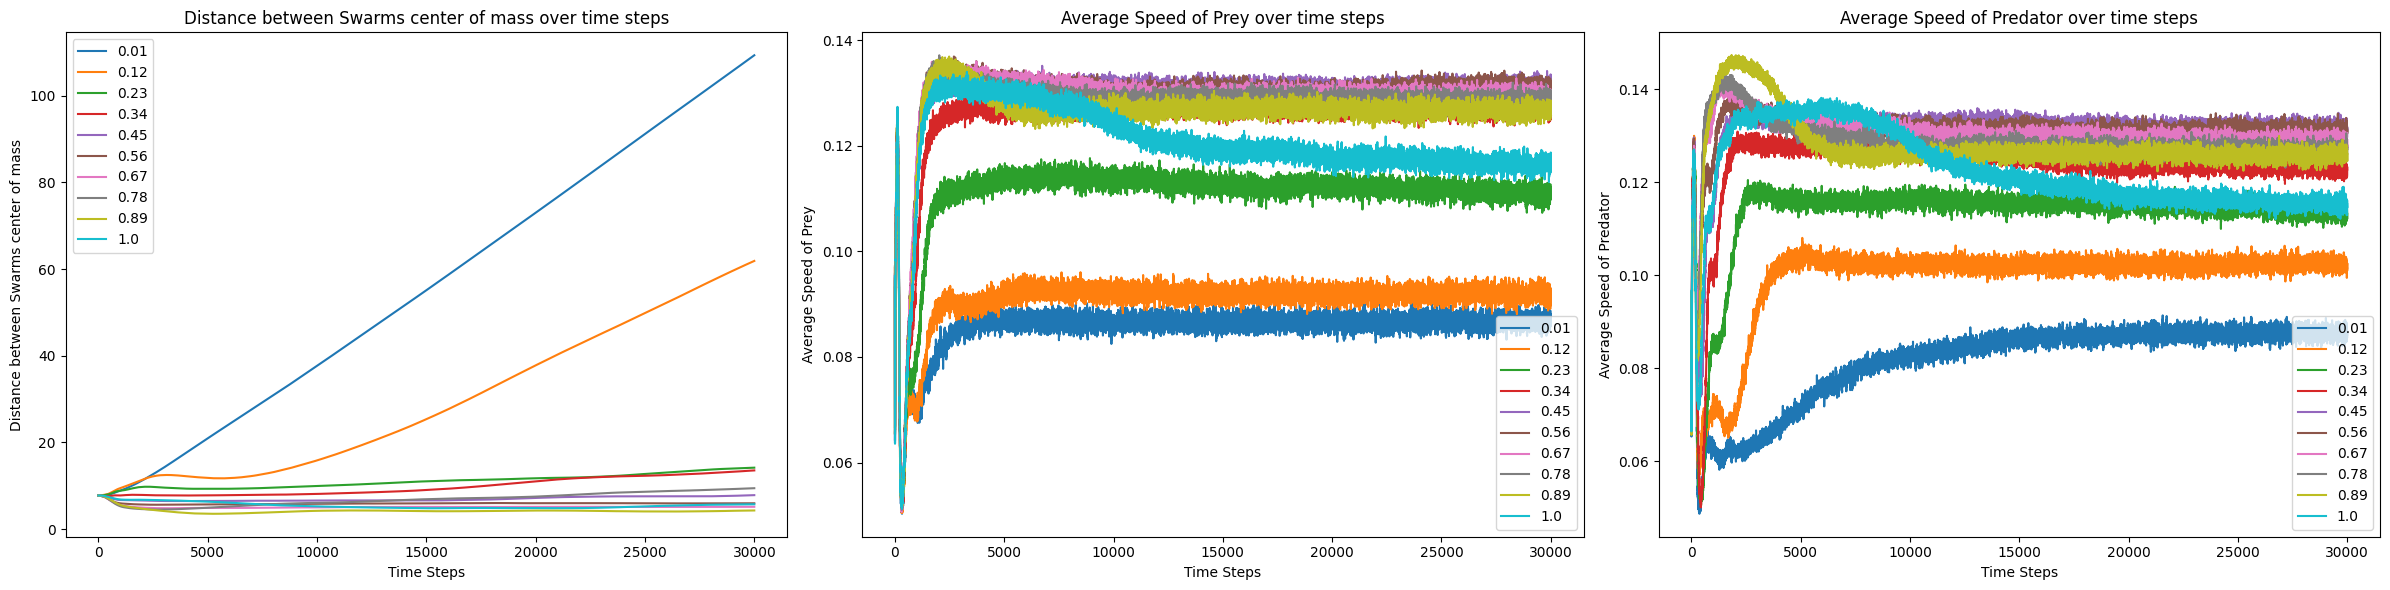

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['boxplots_normalP_vector']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100]
N_agent = [100]
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 10)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[False]_exp[{exp_id}].npy')

# Initialize variables
experiments = {}

def compute_distances(data: pd.DataFrame) -> tuple:
    prey_df = data[data['isPredator'] == 0]
    predator_df = data[data['isPredator'] == 1]

    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()

    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()

    prey_predator_distances = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)

    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2).groupby(prey_df['step']).mean()
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2).groupby(predator_df['step']).mean()

    return prey_predator_distances, prey_velocities, pred_velocities

# Load and process data
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]

            prey_predator_distances, prey_velocities, pred_velocities = compute_distances(df)
            
            if (exp_id, percentage_no_sensor) not in experiments:
                experiments[(exp_id, percentage_no_sensor)] = []
            experiments[(exp_id, percentage_no_sensor)].append((prey_predator_distances, prey_velocities, pred_velocities))
            
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Aggregate data across all experiment IDs for each condition
distance_data = {}
prey_velocity_data = {}
pred_velocity_data = {}

for key, data in experiments.items():
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in distance_data:
        distance_data[percentage_no_sensor] = []
    if percentage_no_sensor not in prey_velocity_data:
        prey_velocity_data[percentage_no_sensor] = []
    if percentage_no_sensor not in pred_velocity_data:
        pred_velocity_data[percentage_no_sensor] = []

    for distances, prey_velocities, pred_velocities in data:
        distance_data[percentage_no_sensor].append(distances)
        prey_velocity_data[percentage_no_sensor].append(prey_velocities)
        pred_velocity_data[percentage_no_sensor].append(pred_velocities)

# Calculate average distances and velocities over time
avg_distances = {p: np.mean(np.vstack(distance_data[p]), axis=0) for p in distance_data}
avg_prey_velocities = {p: np.mean(np.vstack(prey_velocity_data[p]), axis=0) for p in prey_velocity_data}
avg_pred_velocities = {p: np.mean(np.vstack(pred_velocity_data[p]), axis=0) for p in pred_velocity_data}

fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

# Plot distances
for p in sorted(avg_distances.keys(), reverse=True):
    ax[0].plot(avg_distances[p], label=f'{round(1 - float(p), 2)}')
ax[0].set_xlabel('Time Steps')
ax[0].set_ylabel('Distance between Swarms center of mass')
ax[0].set_title('Distance between Swarms center of mass over time steps')
ax[0].legend()

# Plot average prey velocities over time
for p in sorted(avg_prey_velocities.keys(), reverse=True):
    ax[1].plot(avg_prey_velocities[p], label=f'{round(1 - float(p), 2)}')
ax[1].set_xlabel('Time Steps')
ax[1].set_ylabel('Average Speed of Prey')
ax[1].set_title('Average Speed of Prey over time steps')
ax[1].legend()

# Plot average predator velocities over time
for p in sorted(avg_pred_velocities.keys(), reverse=True):
    ax[2].plot(avg_pred_velocities[p], label=f'{round(1 - float(p), 2)}')
ax[2].set_xlabel('Time Steps')
ax[2].set_ylabel('Average Speed of Predator')
ax[2].set_title('Average Speed of Predator over time steps')
ax[2].legend()

plt.tight_layout()
plt.show()


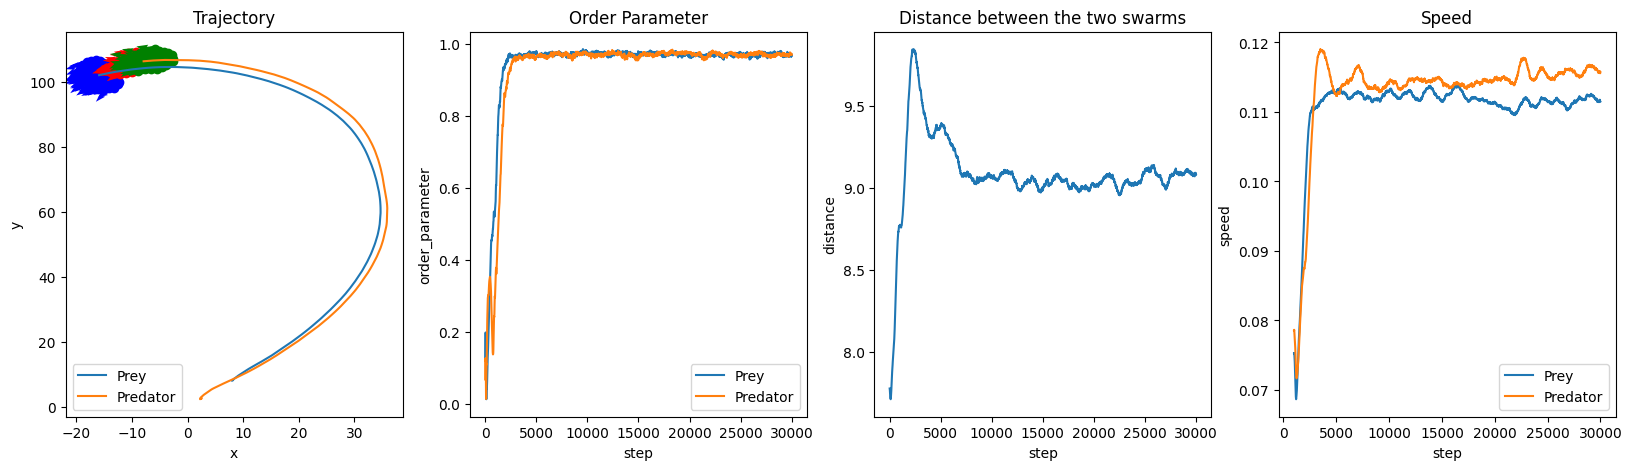

In [8]:
file = 'dataPreyPredator/boxplots_normalP_vector/Agents[100]_Preys[100]_steps[30000]_precentageNoSensor[0.77]_sensingRange[3]_sensorRange[3]_pdm[False]_exp[2].npy'
data = np.load(file)
plot_data(data, "file")

# sensing Range Ratios

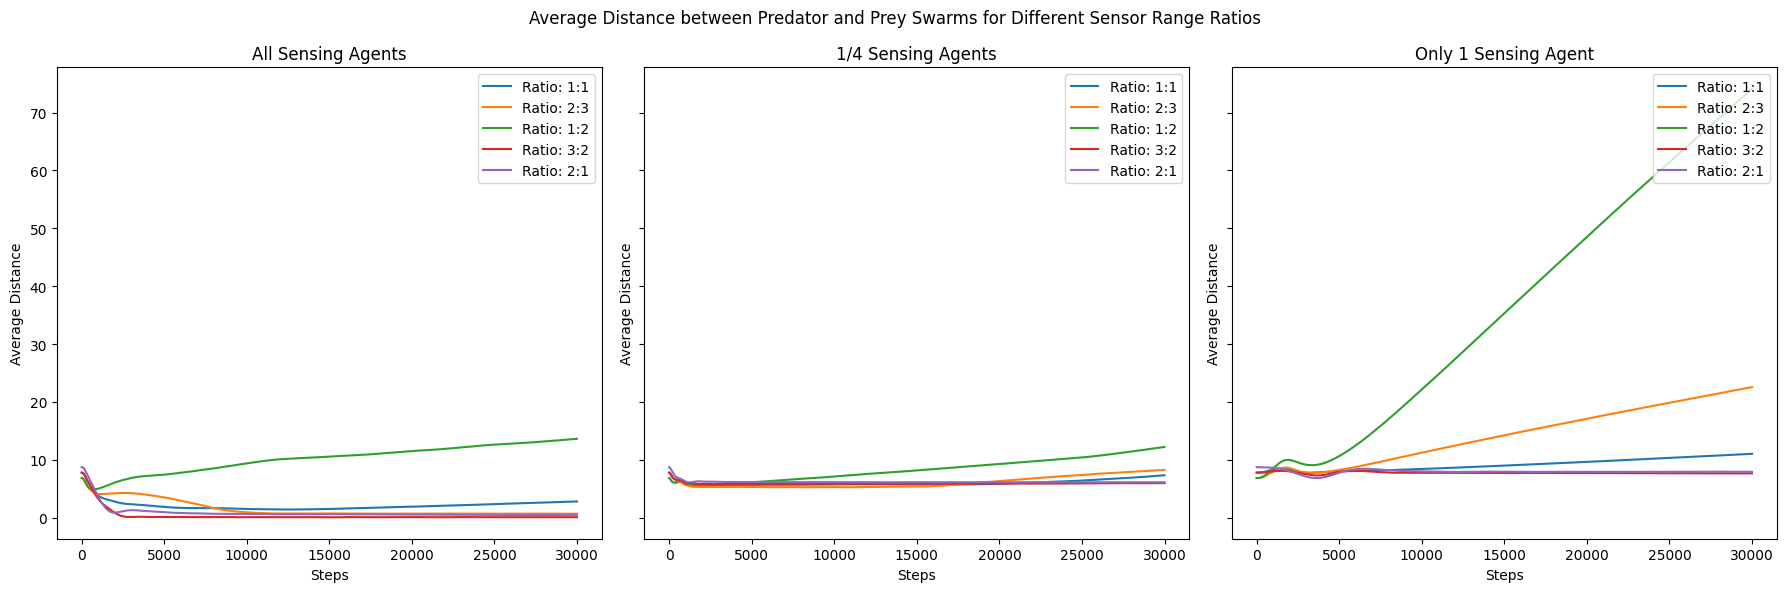

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['sensing_ranges_PADM']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100]
N_agent = [100]
sensing_range = [2, 3, 4]  # Prey
sensor_range = [2, 3, 4]  # Predator
percentage_no_sensor = [0.0, 0.75, 0.99]
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# Compute allowed ratios
allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Generate valid combinations
valid_combinations = [(sr, sensing_r) for sr in sensor_range for sensing_r in sensing_range if Fraction(sr, sensing_r) in allowed_ratios]

# Generate file names
file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].npy')

# Function to compute distances
def compute_distances(df):
    predator_df = df[df['isPredator'] == 1]
    prey_df = df[df['isPredator'] == 0]
    
    predator_distances = predator_df.groupby('step')[['x', 'y']].mean()
    prey_distances = prey_df.groupby('step')[['x', 'y']].mean()
    
    prey_predator_distances = np.linalg.norm(prey_distances.values - predator_distances.values, axis=1)
    return prey_predator_distances

# Load and process DataFrames from .npy files
experiments = {}
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]
            sensor_range_ = int(file.split('sensorRange[')[1].split(']')[0])
            sensing_range_ = int(file.split('sensingRange[')[1].split(']')[0])

            prey_predator_distances = compute_distances(df)
            key = (exp_id, percentage_no_sensor, sensor_range_, sensing_range_)
            if key not in experiments:
                experiments[key] = []
            experiments[key].append(prey_predator_distances)
            
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Step 1: Aggregate the data across all experiment IDs for each condition
prey_predator_distances_per_ratio = {}
for key, results in experiments.items():
    exp_id, percentage_no_sensor, sensor_range_, sensing_range_ = key
    ratio = Fraction(sensor_range_, sensing_range_)
    condition_key = (f"{ratio.numerator}:{ratio.denominator}", percentage_no_sensor)
    if condition_key not in prey_predator_distances_per_ratio:
        prey_predator_distances_per_ratio[condition_key] = []
    prey_predator_distances_per_ratio[condition_key].extend(results)

# Step 2: Calculate the average distance per step for each condition
avg_distance_per_step = {}
for key, distances in prey_predator_distances_per_ratio.items():
    # Compute the average distance for each step across all experiments
    all_distances = np.vstack(distances)
    avg_distances = np.mean(all_distances, axis=0)
    avg_distance_per_step[key] = avg_distances

# Step 3: Plot the averages per step with legends representing ratio and percentage no sensor
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
steps = np.arange(total_steps_per_simulation)

for key, avg_distances in avg_distance_per_step.items():
    ratio, percentage_no_sensor = key
    if percentage_no_sensor == '0.0':
        ax[0].plot(steps, avg_distances, label=f'Ratio: {ratio}')
        ax[0].set_xlabel('Steps')
        ax[0].set_ylabel('Average Distance')
        ax[0].set_title('All Sensing Agents')
    elif percentage_no_sensor == '0.75':
        ax[1].plot(steps, avg_distances, label=f'Ratio: {ratio}')
        ax[1].set_xlabel('Steps')
        ax[1].set_ylabel('Average Distance')
        ax[1].set_title('1/4 Sensing Agents')
    elif percentage_no_sensor == '0.99':
        ax[2].plot(steps, avg_distances, label=f'Ratio: {ratio}')
        ax[2].set_xlabel('Steps')
        ax[2].set_ylabel('Average Distance')
        ax[2].set_title('Only 1 Sensing Agent')

# Adjust the legend and titles
for axis in ax:
    axis.legend(loc='upper right')

plt.suptitle('Average Distance between Predator and Prey Swarms for Different Sensor Range Ratios')
plt.tight_layout()
plt.show()


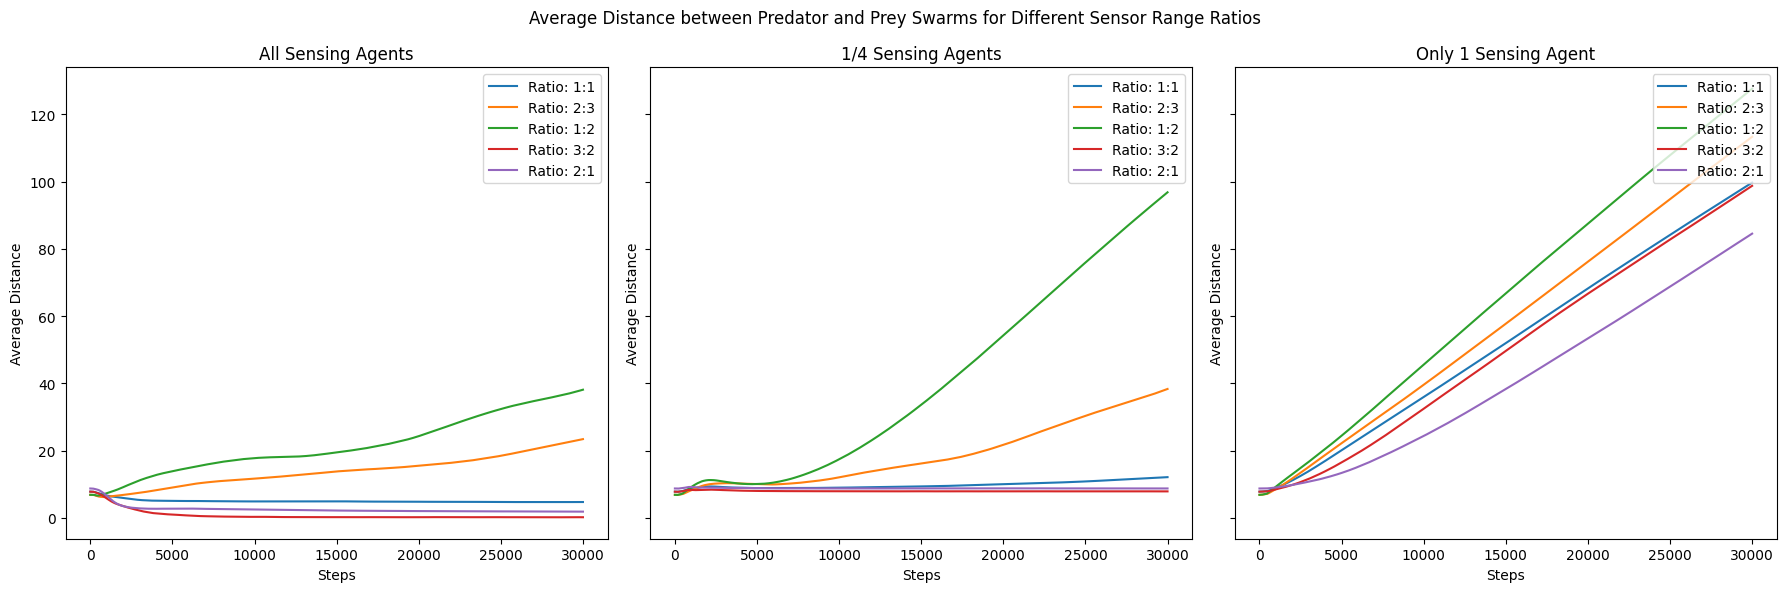

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['sensing_ranges_PDM']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100]
N_agent = [100]
sensing_range = [2, 3, 4]  # Prey
sensor_range = [2, 3, 4]  # Predator
percentage_no_sensor = [0.0, 0.75, 0.99]
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# Compute allowed ratios
allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Generate valid combinations
valid_combinations = [(sr, sensing_r) for sr in sensor_range for sensing_r in sensing_range if Fraction(sr, sensing_r) in allowed_ratios]

# Generate file names
file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[False]_exp[{exp_id}].npy')

# Function to compute distances
def compute_distances(df):
    predator_df = df[df['isPredator'] == 1]
    prey_df = df[df['isPredator'] == 0]
    
    predator_distances = predator_df.groupby('step')[['x', 'y']].mean()
    prey_distances = prey_df.groupby('step')[['x', 'y']].mean()
    
    prey_predator_distances = np.linalg.norm(prey_distances.values - predator_distances.values, axis=1)
    return prey_predator_distances

# Load and process DataFrames from .npy files
experiments = {}
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]
            sensor_range_ = int(file.split('sensorRange[')[1].split(']')[0])
            sensing_range_ = int(file.split('sensingRange[')[1].split(']')[0])

            prey_predator_distances = compute_distances(df)
            key = (exp_id, percentage_no_sensor, sensor_range_, sensing_range_)
            if key not in experiments:
                experiments[key] = []
            experiments[key].append(prey_predator_distances)
            
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Step 1: Aggregate the data across all experiment IDs for each condition
prey_predator_distances_per_ratio = {}
for key, results in experiments.items():
    exp_id, percentage_no_sensor, sensor_range_, sensing_range_ = key
    ratio = Fraction(sensor_range_, sensing_range_)
    condition_key = (f"{ratio.numerator}:{ratio.denominator}", percentage_no_sensor)
    if condition_key not in prey_predator_distances_per_ratio:
        prey_predator_distances_per_ratio[condition_key] = []
    prey_predator_distances_per_ratio[condition_key].extend(results)

# Step 2: Calculate the average distance per step for each condition
avg_distance_per_step = {}
for key, distances in prey_predator_distances_per_ratio.items():
    # Compute the average distance for each step across all experiments
    all_distances = np.vstack(distances)
    avg_distances = np.mean(all_distances, axis=0)
    avg_distance_per_step[key] = avg_distances

# Step 3: Plot the averages per step with legends representing ratio and percentage no sensor
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
steps = np.arange(total_steps_per_simulation)

for key, avg_distances in avg_distance_per_step.items():
    ratio, percentage_no_sensor = key
    if percentage_no_sensor == '0.0':
        ax[0].plot(steps, avg_distances, label=f'Ratio: {ratio}')
        ax[0].set_xlabel('Steps')
        ax[0].set_ylabel('Average Distance')
        ax[0].set_title('All Sensing Agents')
    elif percentage_no_sensor == '0.75':
        ax[1].plot(steps, avg_distances, label=f'Ratio: {ratio}')
        ax[1].set_xlabel('Steps')
        ax[1].set_ylabel('Average Distance')
        ax[1].set_title('1/4 Sensing Agents')
    elif percentage_no_sensor == '0.99':
        ax[2].plot(steps, avg_distances, label=f'Ratio: {ratio}')
        ax[2].set_xlabel('Steps')
        ax[2].set_ylabel('Average Distance')
        ax[2].set_title('Only 1 Sensing Agent')

# Adjust the legend and titles
for axis in ax:
    axis.legend(loc='upper right')

plt.suptitle('Average Distance between Predator and Prey Swarms for Different Sensor Range Ratios')
plt.tight_layout()
plt.show()


# Different Swarm sizes

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['swarm_sizes']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100, 50]  # Modified to include 50 as an example
N_agent = [100, 50]  # Modified to include 50 as an example
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = [0.0, 0.75, 0.99]
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# Calculate allowed ratios
allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate valid combinations
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

# Generate file names
file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].npy')

# Initialize variables
experiments = {}

def compute_distances(data: pd.DataFrame) -> tuple:
    prey_df = data[data['isPredator'] == 0]
    predator_df = data[data['isPredator'] == 1]

    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()

    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()

    prey_predator_distances = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)

    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2).groupby(prey_df['step']).mean()
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2).groupby(predator_df['step']).mean()

    return prey_predator_distances, prey_velocities, pred_velocities

# Load and process data
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]
            N_agent_ = file.split('Agents[')[1].split(']')[0]
            N_prey = file.split('Preys[')[1].split(']')[0]

            prey_predator_distances, prey_velocities, pred_velocities = compute_distances(df)
            
            key = (exp_id, percentage_no_sensor, N_agent_, N_prey)
            if key not in experiments:
                experiments[key] = []
            experiments[key].append((prey_predator_distances, prey_velocities, pred_velocities))
            
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Aggregate data across all experiment IDs for each condition
distance_data = {}
prey_velocity_data = {}
pred_velocity_data = {}

for key, data in experiments.items():
    percentage_no_sensor = key[1]
    N_agent_ = key[2]
    N_prey = key[3]
    
    condition_key = (percentage_no_sensor, N_agent_, N_prey)
    
    if condition_key not in distance_data:
        distance_data[condition_key] = []
    if condition_key not in prey_velocity_data:
        prey_velocity_data[condition_key] = []
    if condition_key not in pred_velocity_data:
        pred_velocity_data[condition_key] = []

    for distances, prey_velocities, pred_velocities in data:
        distance_data[condition_key].append(distances)
        prey_velocity_data[condition_key].append(prey_velocities)
        pred_velocity_data[condition_key].append(pred_velocities)

# Calculate average distances and velocities over time
avg_distances = {key: np.mean(np.vstack(distance_data[key]), axis=0) for key in distance_data}
avg_prey_velocities = {key: np.mean(np.vstack(prey_velocity_data[key]), axis=0) for key in prey_velocity_data}
avg_pred_velocities = {key: np.mean(np.vstack(pred_velocity_data[key]), axis=0) for key in pred_velocity_data}

# fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

# handles = []
# labels = []

# # Plot distances
# for key in sorted(avg_distances.keys()):
#     percentage_no_sensor, N_agent_, N_prey = key
#     label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
#     line, = ax[0].plot(avg_distances[key], label=label)
#     handles.append(line)
#     labels.append(label)
# ax[0].set_xlabel('Time Steps')
# ax[0].set_ylabel('Distance between Swarms center of mass')
# ax[0].set_title('Distance between Swarms center of mass over time steps')

# # Plot average prey velocities over time
# for key in sorted(avg_prey_velocities.keys()):
#     percentage_no_sensor, N_agent_, N_prey = key
#     label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
#     line, = ax[1].plot(avg_prey_velocities[key], label=label)
#     handles.append(line)
#     # labels.append(label)
# ax[1].set_xlabel('Time Steps')
# ax[1].set_ylabel('Average Speed of Prey')
# ax[1].set_title('Average Speed of Prey over time steps')

# # Plot average predator velocities over time
# for key in sorted(avg_pred_velocities.keys()):
#     percentage_no_sensor, N_agent_, N_prey = key
#     label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
#     line, = ax[2].plot(avg_pred_velocities[key], label=label)
#     handles.append(line)
#     # labels.append(label)
# ax[2].set_xlabel('Time Steps')
# ax[2].set_ylabel('Average Speed of Predator')
# ax[2].set_title('Average Speed of Predator over time steps')

# # Create a single legend
# fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


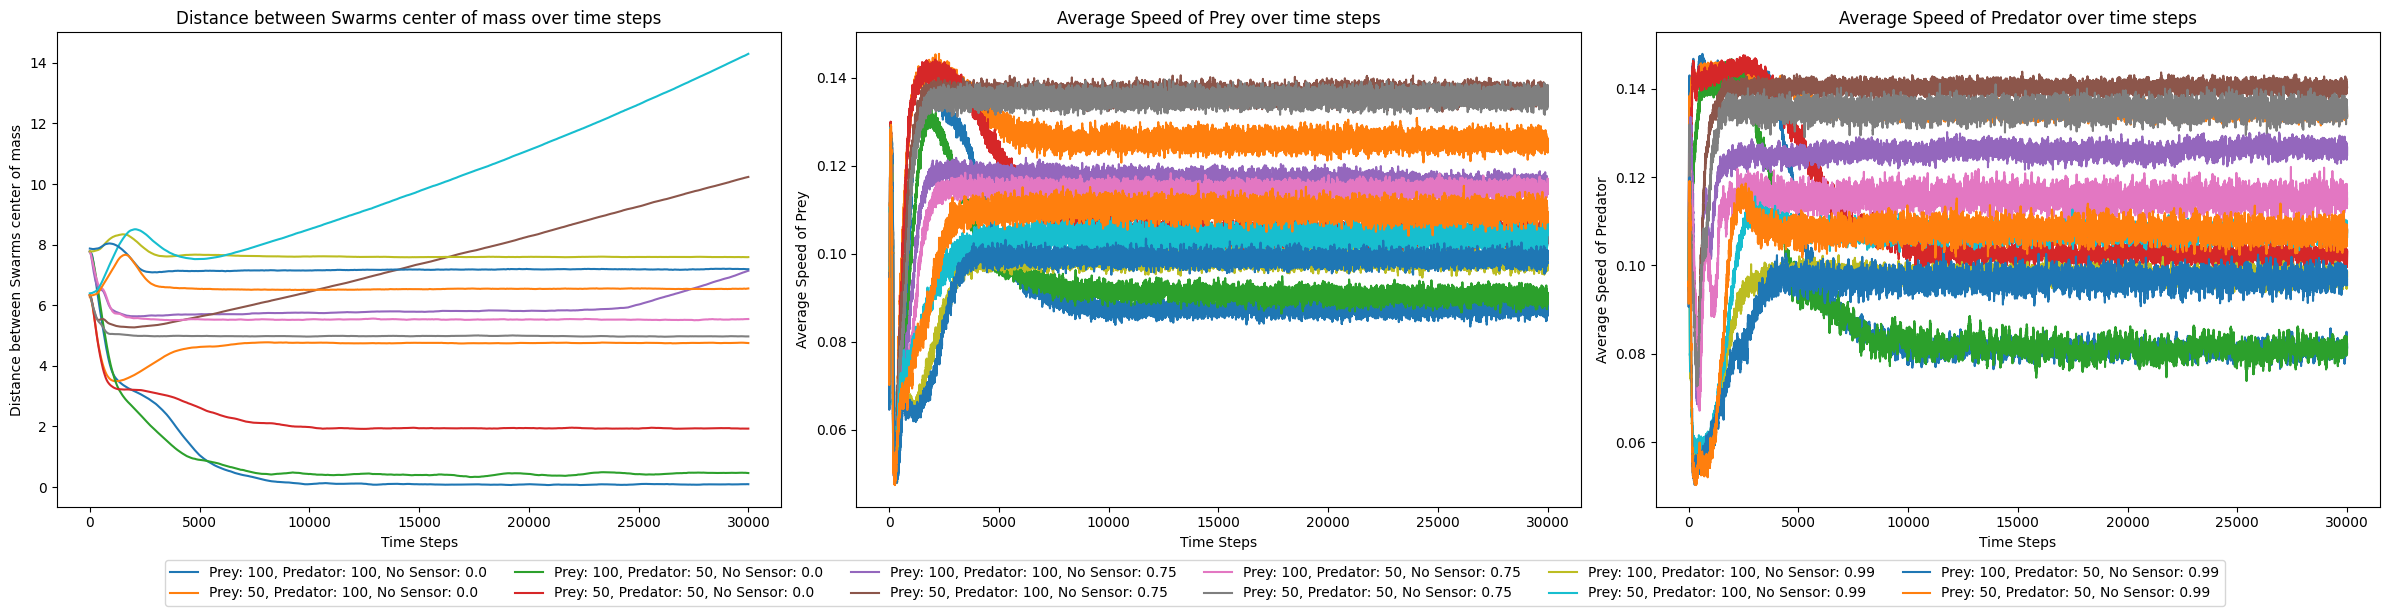

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

handles = []
labels = []

# Plot distances
for key in sorted(avg_distances.keys()):
    percentage_no_sensor, N_agent_, N_prey = key
    label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
    line, = ax[0].plot(avg_distances[key], label=label)
    handles.append(line)
    labels.append(label)
ax[0].set_xlabel('Time Steps')
ax[0].set_ylabel('Distance between Swarms center of mass')
ax[0].set_title('Distance between Swarms center of mass over time steps')

# Plot average prey velocities over time
for key in sorted(avg_prey_velocities.keys()):
    percentage_no_sensor, N_agent_, N_prey = key
    label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
    line, = ax[1].plot(avg_prey_velocities[key], label=label)
    handles.append(line)
    # labels.append(label)
ax[1].set_xlabel('Time Steps')
ax[1].set_ylabel('Average Speed of Prey')
ax[1].set_title('Average Speed of Prey over time steps')

# Plot average predator velocities over time
for key in sorted(avg_pred_velocities.keys()):
    percentage_no_sensor, N_agent_, N_prey = key
    label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
    line, = ax[2].plot(avg_pred_velocities[key], label=label)
    handles.append(line)
    # labels.append(label)
ax[2].set_xlabel('Time Steps')
ax[2].set_ylabel('Average Speed of Predator')
ax[2].set_title('Average Speed of Predator over time steps')

# Create a single legend
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from fractions import Fraction
from itertools import product

# Parameters
num_exps = 35
folders = ['swarm_sizes_PDM']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [100, 50]  # Modified to include 50 as an example
N_agent = [100, 50]  # Modified to include 50 as an example
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = [0.0, 0.75, 0.99]
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# Calculate allowed ratios
allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate valid combinations
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

# Generate file names
file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[False]_exp[{exp_id}].npy')

# Initialize variables
experiments = {}

def compute_distances(data: pd.DataFrame) -> tuple:
    prey_df = data[data['isPredator'] == 0]
    predator_df = data[data['isPredator'] == 1]

    prey_means = prey_df.groupby('step')[['x', 'y']].mean()
    predator_means = predator_df.groupby('step')[['x', 'y']].mean()

    swarm_pred_center_per_step = predator_means.to_numpy()
    swarm_prey_center_per_step = prey_means.to_numpy()

    prey_predator_distances = np.linalg.norm(swarm_prey_center_per_step - swarm_pred_center_per_step, axis=1)

    prey_velocities = np.sqrt(prey_df['vx']**2 + prey_df['vy']**2).groupby(prey_df['step']).mean()
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2).groupby(predator_df['step']).mean()

    return prey_predator_distances, prey_velocities, pred_velocities

# Load and process data
for file in file_names:
    for folder in folders:
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                             'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                             'step', 'isPredator'])
            percentage_no_sensor = file.split('precentageNoSensor[')[1].split(']')[0]
            exp_id = file.split('exp[')[1].split('].npy')[0]
            N_agent_ = file.split('Agents[')[1].split(']')[0]
            N_prey = file.split('Preys[')[1].split(']')[0]

            prey_predator_distances, prey_velocities, pred_velocities = compute_distances(df)
            
            key = (exp_id, percentage_no_sensor, N_agent_, N_prey)
            if key not in experiments:
                experiments[key] = []
            experiments[key].append((prey_predator_distances, prey_velocities, pred_velocities))
            
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Aggregate data across all experiment IDs for each condition
distance_data = {}
prey_velocity_data = {}
pred_velocity_data = {}

for key, data in experiments.items():
    percentage_no_sensor = key[1]
    N_agent_ = key[2]
    N_prey = key[3]
    
    condition_key = (percentage_no_sensor, N_agent_, N_prey)
    
    if condition_key not in distance_data:
        distance_data[condition_key] = []
    if condition_key not in prey_velocity_data:
        prey_velocity_data[condition_key] = []
    if condition_key not in pred_velocity_data:
        pred_velocity_data[condition_key] = []

    for distances, prey_velocities, pred_velocities in data:
        distance_data[condition_key].append(distances)
        prey_velocity_data[condition_key].append(prey_velocities)
        pred_velocity_data[condition_key].append(pred_velocities)

# Calculate average distances and velocities over time
avg_distances = {key: np.mean(np.vstack(distance_data[key]), axis=0) for key in distance_data}
avg_prey_velocities = {key: np.mean(np.vstack(prey_velocity_data[key]), axis=0) for key in prey_velocity_data}
avg_pred_velocities = {key: np.mean(np.vstack(pred_velocity_data[key]), axis=0) for key in pred_velocity_data}

# fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

# handles = []
# labels = []

# # Plot distances
# for key in sorted(avg_distances.keys()):
#     percentage_no_sensor, N_agent_, N_prey = key
#     label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
#     line, = ax[0].plot(avg_distances[key], label=label)
#     handles.append(line)
#     labels.append(label)
# ax[0].set_xlabel('Time Steps')
# ax[0].set_ylabel('Distance between Swarms center of mass')
# ax[0].set_title('Distance between Swarms center of mass over time steps')

# # Plot average prey velocities over time
# for key in sorted(avg_prey_velocities.keys()):
#     percentage_no_sensor, N_agent_, N_prey = key
#     label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
#     line, = ax[1].plot(avg_prey_velocities[key], label=label)
#     handles.append(line)
#     # labels.append(label)
# ax[1].set_xlabel('Time Steps')
# ax[1].set_ylabel('Average Speed of Prey')
# ax[1].set_title('Average Speed of Prey over time steps')

# # Plot average predator velocities over time
# for key in sorted(avg_pred_velocities.keys()):
#     percentage_no_sensor, N_agent_, N_prey = key
#     label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
#     line, = ax[2].plot(avg_pred_velocities[key], label=label)
#     handles.append(line)
#     # labels.append(label)
# ax[2].set_xlabel('Time Steps')
# ax[2].set_ylabel('Average Speed of Predator')
# ax[2].set_title('Average Speed of Predator over time steps')

# # Create a single legend
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


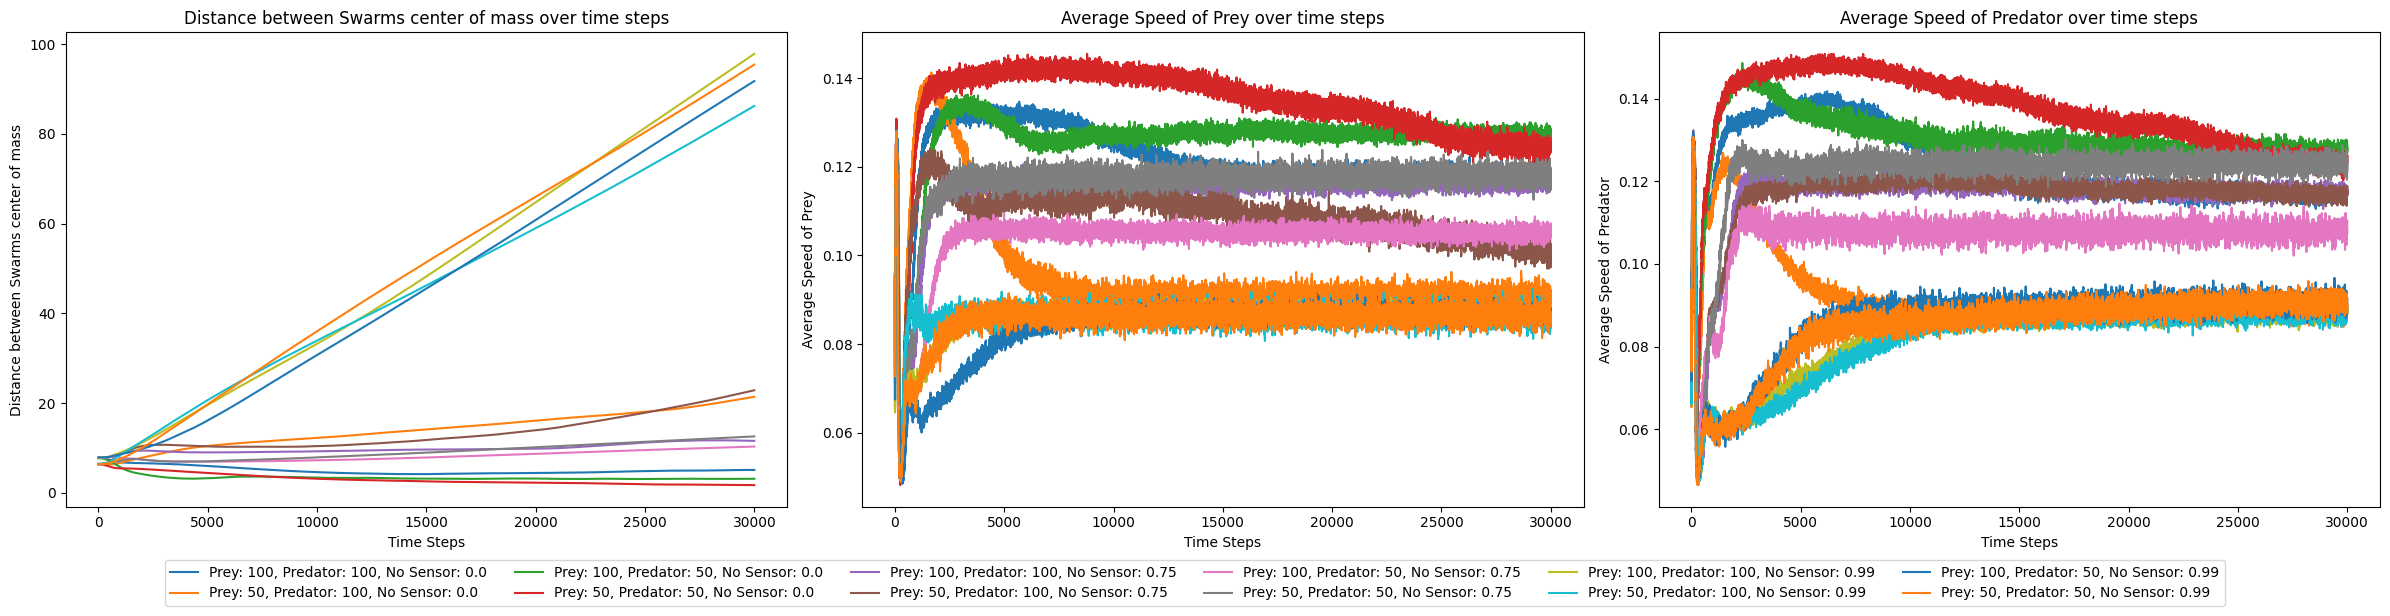

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

handles = []
labels = []

# Plot distances
for key in sorted(avg_distances.keys()):
    percentage_no_sensor, N_agent_, N_prey = key
    label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
    line, = ax[0].plot(avg_distances[key], label=label)
    handles.append(line)
    labels.append(label)
ax[0].set_xlabel('Time Steps')
ax[0].set_ylabel('Distance between Swarms center of mass')
ax[0].set_title('Distance between Swarms center of mass over time steps')

# Plot average prey velocities over time
for key in sorted(avg_prey_velocities.keys()):
    percentage_no_sensor, N_agent_, N_prey = key
    label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
    line, = ax[1].plot(avg_prey_velocities[key], label=label)
    handles.append(line)
    # labels.append(label)
ax[1].set_xlabel('Time Steps')
ax[1].set_ylabel('Average Speed of Prey')
ax[1].set_title('Average Speed of Prey over time steps')

# Plot average predator velocities over time
for key in sorted(avg_pred_velocities.keys()):
    percentage_no_sensor, N_agent_, N_prey = key
    label = f'Prey: {N_prey}, Predator: {N_agent_}, No Sensor: {percentage_no_sensor}'
    line, = ax[2].plot(avg_pred_velocities[key], label=label)
    handles.append(line)
    # labels.append(label)
ax[2].set_xlabel('Time Steps')
ax[2].set_ylabel('Average Speed of Predator')
ax[2].set_title('Average Speed of Predator over time steps')

# Create a single legend
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


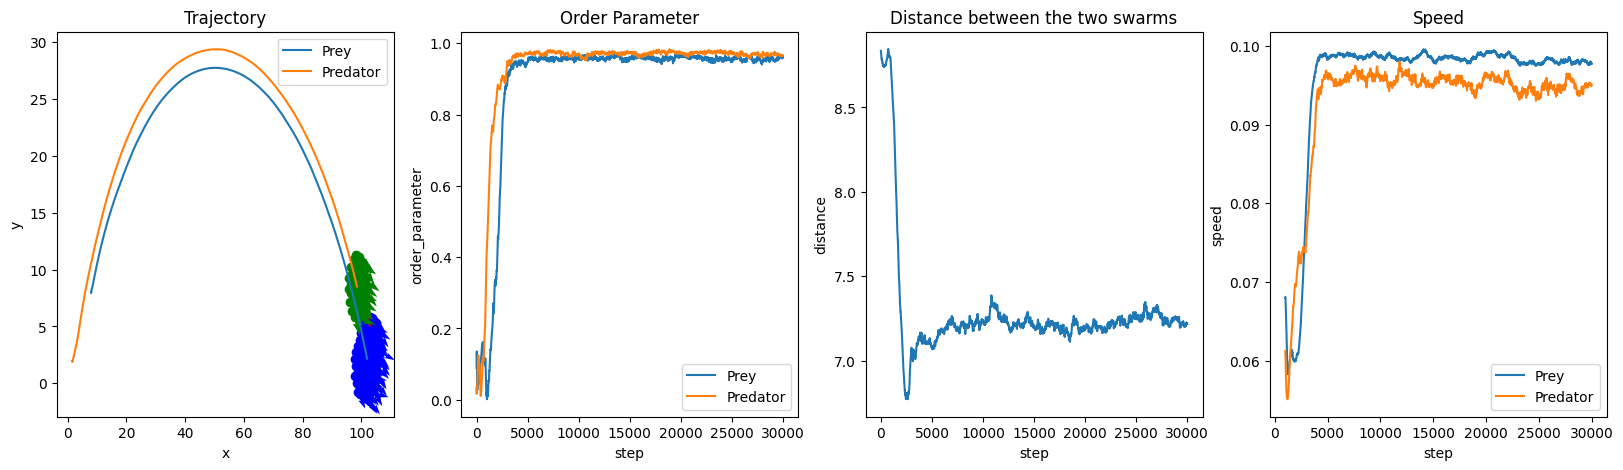

In [9]:
file = 'dataPreyPredator/swarm_sizes/Agents[50]_Preys[100]_steps[30000]_precentageNoSensor[0.99]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[1].npy'
data = np.load(file)
plot_data(data, "file")

Text(0.5, 1.0, 'Kappa vs Predator Distance')

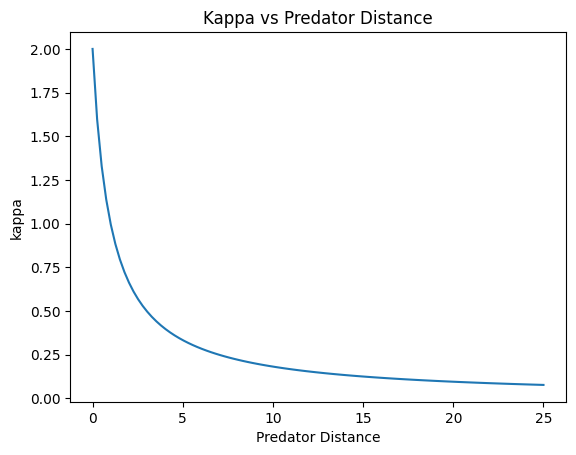

In [4]:
import numpy as np
import matplotlib.pyplot as plt
distances = np.linspace(0, 25, 100)
weights = 2/(1+distances**(1))
# print(weights)
# weights = weights / np.sum(weights)
# print(sum(weights))
plt.plot(distances, weights)
plt.ylabel('kappa')
plt.xlabel('Predator Distance')
plt.title('Kappa vs Predator Distance')

# P-DM vs P-ADM no Preys

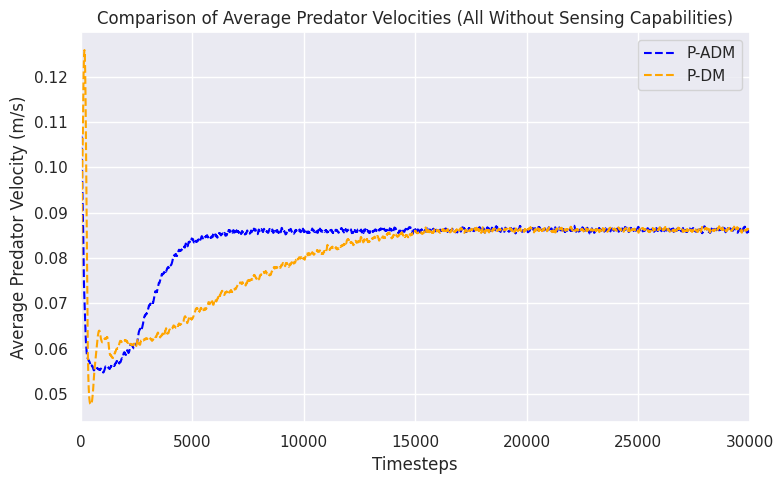

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fractions import Fraction
from itertools import product

# Set the seaborn style
sns.set_theme()

# Parameters
num_exps = 35
folders = ['adm_vs_dm']  # Two folders for the two methods
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [0]
N_agent = [100]
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = [0.0, 1.0]
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

allowed_ratios = {Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios}
allowed_reversed_ratios = {Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios}
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = [(sr, sensing_r) for sr in sensor_range for sensing_r in sensing_range if Fraction(sr, sensing_r) in allowed_ratios or (sensing_r, sr) in allowed_ratios]

file_names = {
    0.0: [],
    1.0: []
}
file_names2 = {
    0.0: [],
    1.0: []
}
for folder in folders:
    for exp_id in experiment_id_:
        for N_prey in N_preys:
            for percentage in percentage_no_sensor:
                for N_agent_ in N_agent:
                    for (sensor_range_, sensing_range_) in valid_combinations:
                        try:
                            file_names[percentage].append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].npy')
                        except FileNotFoundError:
                            pass
                        try:
                            file_names2[percentage].append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[False]_exp[{exp_id}].npy')
                        except FileNotFoundError:
                            pass

# Initialize variables
predator_velocities = {0.0: {'adm_vs_dm': [], 'adm_vs_dm_pdm': []}, 1.0: {'adm_vs_dm': [], 'adm_vs_dm_pdm': []}}

def compute_predator_velocities(data: pd.DataFrame) -> np.ndarray:
    predator_df = data[data['isPredator'] == 1]
    pred_velocities = np.sqrt(predator_df['vx']**2 + predator_df['vy']**2)
    pred_velocities_by_step = pred_velocities.groupby(predator_df['step']).mean()
    return pred_velocities_by_step

# Load and process data
for percentage in percentage_no_sensor:
    for file in file_names[percentage]:
        folder = 'adm_vs_dm'
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                                'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                                'step', 'isPredator'])
            # Limit data to the maximum number of steps
            df = df[df['step'] <= total_steps_per_simulation]
            # Compute predator velocities
            pred_velocities = compute_predator_velocities(df)
            predator_velocities[percentage]['adm_vs_dm'].append(pred_velocities)
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')
    for file in file_names2[percentage]:
        folder = 'adm_vs_dm'
        try:
            data = np.load(f'dataPreyPredator/{folder}/{file}')
            df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'distanceSensor', 'id', 'distance', 'U_i', 'omega_i', 
                                                'maxAngularVelocity', 'maxLinearVelocity', 'alpha', 'kappa', 'vx', 'vy', 
                                                'step', 'isPredator'])
            # Limit data to the maximum number of steps
            df = df[df['step'] <= total_steps_per_simulation]
            # Compute predator velocities
            pred_velocities = compute_predator_velocities(df)
            predator_velocities[percentage]['adm_vs_dm_pdm'].append(pred_velocities)
            # Clear large data
            del data, df
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# Prepare data for plotting
def prepare_plot_data(predator_velocities, percentage):
    method1_data = np.vstack([vel.reindex(range(total_steps_per_simulation), fill_value=0) for vel in predator_velocities[percentage]['adm_vs_dm']])
    method2_data = np.vstack([vel.reindex(range(total_steps_per_simulation), fill_value=0) for vel in predator_velocities[percentage]['adm_vs_dm_pdm']])

    avg_predator_velocities_method1 = np.mean(method1_data, axis=0)
    avg_predator_velocities_method2 = np.mean(method2_data, axis=0)

    # Smooth velocities using moving average
    window_size = 100
    smoothed_velocities_method1 = pd.Series(avg_predator_velocities_method1).rolling(window=window_size, min_periods=1).mean()
    smoothed_velocities_method2 = pd.Series(avg_predator_velocities_method2).rolling(window=window_size, min_periods=1).mean()
    
    return smoothed_velocities_method1, smoothed_velocities_method2


# Plot the comparison
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 16))
# for idx, percentage in enumerate(percentage_no_sensor):
#     smoothed_velocities_method1, smoothed_velocities_method2 = prepare_plot_data(predator_velocities, percentage)
#     sns.lineplot(ax=axes[idx], data=smoothed_velocities_method1, label=f'P-ADM', color='blue', linestyle='-' if percentage == 0.0 else '--')
#     sns.lineplot(ax=axes[idx], data=smoothed_velocities_method2, label=f'P-DM', color='orange', linestyle='-' if percentage == 0.0 else '--')
#     axes[idx].set_xlim(0, total_steps_per_simulation)
#     axes[idx].set_xlabel('Timesteps')
#     axes[idx].set_ylabel('Average Predator Velocity (m/s)')
#     # axes[idx].set_title(f'Comparison of Average Predator Velocities (No Sensor: {percentage*100:.0f}%)')
#     axes[idx].set_title(f'Comparison of Average Predator Velocities ({"All Sensing" if percentage == 0.0 else "All Without Sensing Capabilities"})')

#     axes[idx].legend()

# plt.tight_layout()
# plt.savefig('predator_velocities_comparison_no_prey.pdf')
# plt.show()


fig, ax = plt.subplots(figsize=(8, 5))
for percentage in percentage_no_sensor:
    if percentage == 0.0:
        continue  # Skip the "All Sensing" condition
    smoothed_velocities_method1, smoothed_velocities_method2 = prepare_plot_data(predator_velocities, percentage)
    sns.lineplot(ax=ax, data=smoothed_velocities_method1, label='P-ADM', color='blue', linestyle='--')
    sns.lineplot(ax=ax, data=smoothed_velocities_method2, label='P-DM', color='orange', linestyle='--')
    ax.set_xlim(0, total_steps_per_simulation)
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Average Predator Velocity (m/s)')
    ax.set_title('Comparison of Average Predator Velocities (All Without Sensing Capabilities)')
    ax.legend()

plt.tight_layout()
plt.savefig('predator_velocities_comparison_no_prey.pdf')
plt.show()

In [7]:
import plotly.graph_objs as go
from plotly.offline import plot

# Create the Plotly figure
fig = go.Figure()

# Add traces
for percentage in percentage_no_sensor:
    if percentage == 0.0:
        continue  # Skip the "All Sensing" condition
    smoothed_velocities_method1, smoothed_velocities_method2 = prepare_plot_data(predator_velocities, percentage)
    
    fig.add_trace(go.Scatter(
        x=smoothed_velocities_method1.index,
        y=smoothed_velocities_method1,
        mode='lines',
        name='P-ADM (All Without Sensing)',
        line=dict(color='blue', dash='dash')
    ))
    
    fig.add_trace(go.Scatter(
        x=smoothed_velocities_method2.index,
        y=smoothed_velocities_method2,
        mode='lines',
        name='P-DM (All Without Sensing)',
        line=dict(color='orange', dash='dash')
    ))

# Update layout
fig.update_layout(
    height=600,
    width=800,
    title_text="Comparison of Average Predator Velocities (All Without Sensing Capabilities)",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    xaxis_title='Timesteps',
    yaxis_title='Average Predator Velocity (m/s)'
)

plot(fig, filename='comparison_no_preys_all_without_sensing.html', output_type='file', include_plotlyjs='cdn', auto_open=False)

# Show the plot
fig.show()

In [ ]:
# import os

# def rename_files(directory):
#     for filename in os.listdir(directory):
#         if 'Preys[10]' in filename:
#             # Generate the new filename
#             new_filename = filename.replace('Preys[10]', 'Preys[0]')
            
#             # Construct the full path for the old and new filenames
#             old_file_path = os.path.join(directory, filename)
#             new_file_path = os.path.join(directory, new_filename)
            
#             # Rename the file
#             os.rename(old_file_path, new_file_path)
#             print(f'Renamed: {filename} -> {new_filename}')

# # Specify the directory containing the files
# directory = 'dataPreyPredator/adm_vs_dm'
# rename_files(directory)